## channel flow
$
\frac{\partial u}{\partial t} + u\frac{\partial u}{\partial x} + v\frac{\partial u}{\partial y} = -\frac{1}{p}\frac{\partial p}{\partial x} + v(\frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2}) + F_{x}
$
, For x direction 

$
\frac{\partial v}{\partial t} + u\frac{\partial v}{\partial x} + v\frac{\partial v}{\partial y} = -\frac{1}{p}\frac{\partial p}{\partial y} + v(\frac{\partial^2 v}{\partial x^2} + \frac{\partial^2 v}{\partial y^2})
$
, For y direction 


Poisson Equation for pressure and velocity for low viscosity
$
\frac{\partial^2 p}{\partial x^2} + \frac{\partial^2 p}{\partial y^2} = - \rho[(\frac{\partial u}{\partial x})^2 + 2\frac{\partial u}{\partial y}\frac{\partial v}{\partial x} + (\frac{\partial v}{\partial y})^2]
$

let F = 1 (source of flow)

IC and BC:

$u,v,p = 0$

$x = 0$ and $x = 2$ is periodic

$y = 0$ and $y = 2$ $\Rightarrow u = 0, v = 0$

$\frac{\partial p}{\partial y} = 0$ at $y = 0,2$

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation, cm
from mpl_toolkits.mplot3d import Axes3D  

In [14]:
#constants
nx = 20
ny = 20
nt = 100
dx = 2 / nx
dy = 2 / ny
xs = np.linspace(0, 2, nx)
ys = np.linspace(0, 2, ny)
X, Y = np.meshgrid(xs, ys)
F = 1 

rho = 1
nu =0.1
dt = 0.01

#init 
u = np.zeros((ny, nx))
v = np.zeros((ny, nx))
p = np.zeros((ny, nx)) 
b = np.zeros((ny, nx))

 

In [12]:
def create_B(b, rho, dt, u, v, dx, dy):
    
    b[1:-1, 1:-1] = (rho * (1 / dt * 
                    ((u[1:-1, 2:] - u[1:-1, 0:-2]) / (2 * dx) + (v[2:, 1:-1] - v[0:-2, 1:-1]) / (2 * dy)) -
                    ((u[1:-1, 2:] - u[1:-1, 0:-2]) / (2 * dx))**2 -
                      2 * ((u[2:, 1:-1] - u[0:-2, 1:-1]) / (2 * dy) *
                           (v[1:-1, 2:] - v[1:-1, 0:-2]) / (2 * dx))-
                          ((v[2:, 1:-1] - v[0:-2, 1:-1]) / (2 * dy))**2))

#BC x = 2 periodic
    b[1:-1,-1] = (rho * (1 / dt * 
                    ((u[1:-1, 0] - u[1:-1, -2]) / (2 * dx) + (v[2:, -1] - v[0:-2, -1]) / (2 * dy)) -
                    ((u[1:-1, 0] - u[1:-1, -2]) / (2 * dx))**2 -
                      2 * ((u[2:, -1] - u[0:-2, -1]) / (2 * dy) *
                           (v[1:-1, 0] - v[1:-1, -2]) / (2 * dx))-
                          ((v[2:, -1] - v[0:-2, -1]) / (2 * dy))**2))
#BC x = 0 periodic
    b[1:-1,-1] = (rho * (1 / dt * 
                    ((u[1:-1, 1] - u[1:-1, -1]) / (2 * dx) + (v[2:, 0] - v[0:-2, 0]) / (2 * dy)) -
                    ((u[1:-1, 1] - u[1:-1, -1]) / (2 * dx))**2 -
                      2 * ((u[2:, 0] - u[0:-2, 0]) / (2 * dy) *
                           (v[1:-1, -1] - v[1:-1, 1]) / (2 * dx))-
                          ((v[2:, 0] - v[0:-2, 0]) / (2 * dy))**2))

    return b

def pressure_poisson(p, dx, dy, b):
    p0 = p.copy()
    
    for _ in range(50):
        p0 = p.copy()
        p[1:-1, 1:-1] = (((p0[1:-1, 2:] + p0[1:-1, 0:-2]) * dy**2 + 
                          (p0[2:, 1:-1] + p0[0:-2, 1:-1]) * dx**2) /
                          (2 * (dx**2 + dy**2)) -
                          dx**2 * dy**2 / (2 * (dx**2 + dy**2)) * 
                          b[1:-1,1:-1])

#BC x = 2 periodic
        p[1:-1, -1] = (((p0[1:-1, 0] + p0[1:-1, -2]) * dy**2 + 
                          (p0[2:, -1] + p0[0:-2, -1]) * dx**2) /
                          (2 * (dx**2 + dy**2)) -
                          dx**2 * dy**2 / (2 * (dx**2 + dy**2)) * 
                          b[1:-1,-1])
#BC x = 0 periodic
        p[1:-1, 0] = (((p0[1:-1, 1] + p0[1:-1, -1]) * dy**2 + 
                          (p0[2:, 0] + p0[0:-2, 0]) * dx**2) /
                          (2 * (dx**2 + dy**2)) -
                          dx**2 * dy**2 / (2 * (dx**2 + dy**2)) * 
                          b[1:-1,0])
#BC wall dp/dy = 0 at y=0
        p[-1,:] = p[-2,:]
        p[0,:] = p[1,:]

    return p



In [18]:
# sim
def pipe_flow(nt, u, v, dt, dx, dy, p, rho, nu, F):
    b = np.zeros((ny,nx))
    c = 0
    error = 10
    target = 1e-3

    while True:
        u0 = u.copy()
        v0 = v.copy()
        b = create_B(b,rho,dt,u,v,dx,dy)
        p = pressure_poisson(p,dx,dy,b)

        u[1:-1, 1:-1] = (u0[1:-1, 1:-1] - u0[1:-1, 1:-1] * dt / dx * 
                    (u0[1:-1, 1:-1] - u0[1:-1, 0:-2]) - v0[1:-1, 1:-1] * dt / dy * 
                    (u0[1:-1, 1:-1] - u0[0:-2, 1:-1]) - dt / (2 * rho * dx) * 
                    (p[1:-1, 2:] - p[1:-1, 0:-2]) + nu * (dt / dx**2 * 
                    (u0[1:-1, 2:] - 2 * u0[1:-1, 1:-1] + u0[1:-1, 0:-2]) + dt / dy**2 * 
                    (u0[2:, 1:-1] - 2 * u0[1:-1, 1:-1] + u0[0:-2, 1:-1])) + 
                     F * dt)

        v[1:-1, 1:-1] = (v0[1:-1, 1:-1] - u0[1:-1, 1:-1] * dt / dx * 
                    (v0[1:-1, 1:-1] - v0[1:-1, 0:-2]) - v0[1:-1, 1:-1] * dt / dy * 
                    (v0[1:-1, 1:-1] - v0[0:-2, 1:-1]) - dt / (2 * rho * dx) * 
                    (p[1:-1, 2:] - p[1:-1, 0:-2]) + nu * (dt / dx**2 * 
                    (v0[1:-1, 2:] - 2 * v0[1:-1, 1:-1] + v0[1:-1, 0:-2]) + dt / dy**2 * 
                    (v0[2:, 1:-1] - 2 * v0[1:-1, 1:-1] + v0[0:-2, 1:-1])))
###BC x = 0
        u[1:-1, 0] = (u0[1:-1, 0] - u0[1:-1, 0] * dt / dx * 
                    (u0[1:-1, 0] - u0[1:-1, -1]) - v0[1:-1, 0] * dt / dy * 
                    (u0[1:-1, 0] - u0[0:-2, 0]) - dt / (2 * rho * dx) * 
                    (p[1:-1, 1] - p[1:-1, -1]) + nu * (dt / dx**2 * 
                    (u0[1:-1, 1] - 2 * u0[1:-1, 0] + u0[1:-1, -1]) + dt / dy**2 * 
                    (u0[2:, 0] - 2 * u0[1:-1, 0] + u0[0:-2, 0])) + 
                     F * dt)
        v[1:-1, 0] = (v0[1:-1, 0] - u0[1:-1, 0] * dt / dx * 
                    (v0[1:-1, 0] - v0[1:-1, -1]) - v0[1:-1, 0] * dt / dy * 
                    (v0[1:-1, 0] - v0[0:-2, 0]) - dt / (2 * rho * dx) * 
                    (p[1:-1, 1] - p[1:-1, -1]) + nu * (dt / dx**2 * 
                    (v0[1:-1, 1] - 2 * v0[1:-1, 0] + v0[1:-1, -1]) + dt / dy**2 * 
                    (v0[2:, 0] - 2 * v0[1:-1, 0] + v0[0:-2, 0])))     
###BC x = 2
        u[1:-1, -1] = (u0[1:-1, -1] - u0[1:-1, -1] * dt / dx * 
                    (u0[1:-1, -1] - u0[1:-1, -2]) - v0[1:-1, -1] * dt / dy * 
                    (u0[1:-1, -1] - u0[0:-2, -1]) - dt / (2 * rho * dx) * 
                    (p[1:-1, 0] - p[1:-1, -2]) + nu * (dt / dx**2 * 
                    (u0[1:-1, 0] - 2 * u0[1:-1, -1] + u0[1:-1, -2]) + dt / dy**2 * 
                    (u0[2:, -1] - 2 * u0[1:-1, -1] + u0[0:-2, -1])) + 
                     F * dt)
        v[1:-1, -1] = (v0[1:-1, -1] - u0[1:-1, -1] * dt / dx * 
                    (v0[1:-1, -1] - v0[1:-1, -2]) - v0[1:-1, -1] * dt / dy * 
                    (v0[1:-1, -1] - v0[0:-2, -1]) - dt / (2 * rho * dx) * 
                    (p[1:-1, 0] - p[1:-1, -2]) + nu * (dt / dx**2 * 
                    (v0[1:-1, 0] - 2 * v0[1:-1, -1] + v0[1:-1, -2]) + dt / dy**2 * 
                    (v0[2:, -1] - 2 * v0[1:-1, -1] + v0[0:-2, 1])))
        c = c +1                 
        error = abs(np.sum(u) - np.sum(u0))
        if error < target:
            print(c)
            break 
    return v,u,p 




2941


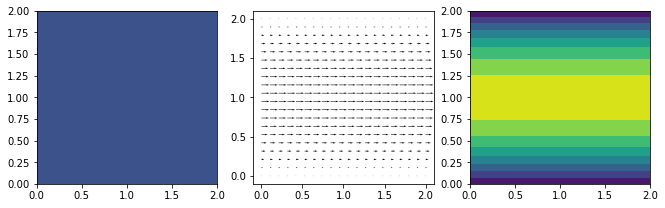

In [29]:
#init 
u = np.zeros((ny, nx))
v = np.zeros((ny, nx))
p = np.zeros((ny, nx)) 
b = np.zeros((ny, nx))

v,u,p = pipe_flow(nt, u, v, dt, dx, dy, p, rho, nu,F)


fig = plt.figure(figsize=(11,7))
plt.subplot(2,3,1)
plt.contourf(X, Y, p, cmap=cm.viridis)  
plt.subplot(2,3,2)
plt.quiver(X, Y, u, v)
plt.subplot(2,3,3)
plt.contourf(X, Y, u, cmap=cm.viridis)


MovieWriter ffmpeg unavailable; using Pillow instead.


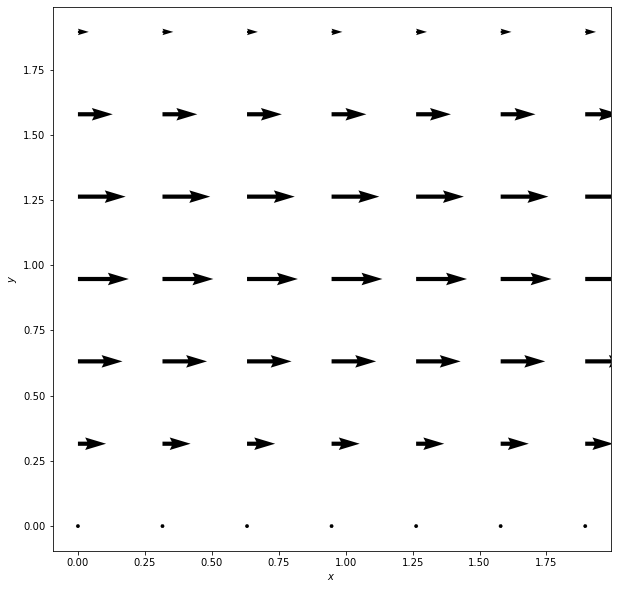

In [35]:
#animate 
#init
u = np.zeros((ny, nx))
v = np.zeros((ny, nx))
p = np.zeros((ny, nx))
b = np.zeros((ny, nx))


fig, ax = plt.subplots()
fig.set_size_inches(10, 10)
skip = 3
cq = ax.quiver(X[::skip, ::skip], Y[::skip, ::skip], u[::skip, ::skip], v[::skip, ::skip])
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')

def init():
    ax.clear()
    cq = ax.quiver(X[::skip, ::skip], Y[::skip, ::skip], u[::skip, ::skip], v[::skip, ::skip])
    return cq

def animate(frames,b,u,v,p):
    u0 = u.copy()
    v0 = v.copy()
    b = create_B(b,rho,dt,u,v,dx,dy)
    p = pressure_poisson(p,dx,dy,b)

    u[1:-1, 1:-1] = (u0[1:-1, 1:-1] - u0[1:-1, 1:-1] * dt / dx * 
                    (u0[1:-1, 1:-1] - u0[1:-1, 0:-2]) - v0[1:-1, 1:-1] * dt / dy * 
                    (u0[1:-1, 1:-1] - u0[0:-2, 1:-1]) - dt / (2 * rho * dx) * 
                    (p[1:-1, 2:] - p[1:-1, 0:-2]) + nu * (dt / dx**2 * 
                    (u0[1:-1, 2:] - 2 * u0[1:-1, 1:-1] + u0[1:-1, 0:-2]) + dt / dy**2 * 
                    (u0[2:, 1:-1] - 2 * u0[1:-1, 1:-1] + u0[0:-2, 1:-1])) + 
                     F * dt)

    v[1:-1, 1:-1] = (v0[1:-1, 1:-1] - u0[1:-1, 1:-1] * dt / dx * 
                    (v0[1:-1, 1:-1] - v0[1:-1, 0:-2]) - v0[1:-1, 1:-1] * dt / dy * 
                    (v0[1:-1, 1:-1] - v0[0:-2, 1:-1]) - dt / (2 * rho * dx) * 
                    (p[1:-1, 2:] - p[1:-1, 0:-2]) + nu * (dt / dx**2 * 
                    (v0[1:-1, 2:] - 2 * v0[1:-1, 1:-1] + v0[1:-1, 0:-2]) + dt / dy**2 * 
                    (v0[2:, 1:-1] - 2 * v0[1:-1, 1:-1] + v0[0:-2, 1:-1])))
###BC x = 0
    u[1:-1, 0] = (u0[1:-1, 0] - u0[1:-1, 0] * dt / dx * 
                    (u0[1:-1, 0] - u0[1:-1, -1]) - v0[1:-1, 0] * dt / dy * 
                    (u0[1:-1, 0] - u0[0:-2, 0]) - dt / (2 * rho * dx) * 
                    (p[1:-1, 1] - p[1:-1, -1]) + nu * (dt / dx**2 * 
                    (u0[1:-1, 1] - 2 * u0[1:-1, 0] + u0[1:-1, -1]) + dt / dy**2 * 
                    (u0[2:, 0] - 2 * u0[1:-1, 0] + u0[0:-2, 0])) + 
                     F * dt)
    v[1:-1, 0] = (v0[1:-1, 0] - u0[1:-1, 0] * dt / dx * 
                    (v0[1:-1, 0] - v0[1:-1, -1]) - v0[1:-1, 0] * dt / dy * 
                    (v0[1:-1, 0] - v0[0:-2, 0]) - dt / (2 * rho * dx) * 
                    (p[1:-1, 1] - p[1:-1, -1]) + nu * (dt / dx**2 * 
                    (v0[1:-1, 1] - 2 * v0[1:-1, 0] + v0[1:-1, -1]) + dt / dy**2 * 
                    (v0[2:, 0] - 2 * v0[1:-1, 0] + v0[0:-2, 0])))     
###BC x = 2
    u[1:-1, -1] = (u0[1:-1, -1] - u0[1:-1, -1] * dt / dx * 
                    (u0[1:-1, -1] - u0[1:-1, -2]) - v0[1:-1, -1] * dt / dy * 
                    (u0[1:-1, -1] - u0[0:-2, -1]) - dt / (2 * rho * dx) * 
                    (p[1:-1, 0] - p[1:-1, -2]) + nu * (dt / dx**2 * 
                    (u0[1:-1, 0] - 2 * u0[1:-1, -1] + u0[1:-1, -2]) + dt / dy**2 * 
                    (u0[2:, -1] - 2 * u0[1:-1, -1] + u0[0:-2, -1])) + 
                     F * dt)
    v[1:-1, -1] = (v0[1:-1, -1] - u0[1:-1, -1] * dt / dx * 
                    (v0[1:-1, -1] - v0[1:-1, -2]) - v0[1:-1, -1] * dt / dy * 
                    (v0[1:-1, -1] - v0[0:-2, -1]) - dt / (2 * rho * dx) * 
                    (p[1:-1, 0] - p[1:-1, -2]) + nu * (dt / dx**2 * 
                    (v0[1:-1, 0] - 2 * v0[1:-1, -1] + v0[1:-1, -2]) + dt / dy**2 * 
                    (v0[2:, -1] - 2 * v0[1:-1, -1] + v0[0:-2, 1])))
    ax.clear()
    cq = ax.quiver(X[::skip, ::skip], Y[::skip, ::skip], u[::skip, ::skip], v[::skip, ::skip])
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')
    return cq

anim = animation.FuncAnimation(fig, animate,init_func=init,fargs=(p,b,u,v),frames=500, repeat=False)
anim.save('pipe flow.gif', fps = 20)
